<a href="https://colab.research.google.com/github/Aditya11013/machine-learning/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# **Data Preparation**

In [ ]:
(x_train,_),(x_test,_) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train,x_test],axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype('float32')/255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(mnist_digits.shape)

(70000, 28, 28, 1)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [ ]:
train_dataset = (
    dataset.shuffle(buffer_size = 1024,reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# **ENCODER**

In [ ]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

In [ ]:

encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x = Conv2D(64,3,activation='relu',strides=2,padding='same')(x)

x = Flatten()(x)
x = Dense(16,activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var],name = 'encoder')

encoder_model.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

# Decoder

In [ ]:
Latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64 , activation='relu')(Latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)

decoder_output = Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
decoder_model = Model(Latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae_input = Input(shape = (28,28,1),name = 'Vae_input')
x,_,_ = encoder_model(vae_input)
output = decoder_model(x)
vae = Model(vae_input,output,name='vae')
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Vae_input (InputLayer)               │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
OPTIMIZER =Adam(learning_rate = 1e-3)
EPOCHS =20

In [ ]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_recons = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis=(1,2)))
  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)),axis = 1))
  return loss_recons+loss_reg



In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred,mean,log_var)

  partial_der = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_der,vae.trainable_weights))
  return loss

In [ ]:
def neuralearn(epochs):
  for epoch in range(epochs):
    print('training starts for epoch number {}'.format(epoch+1))

    for step,x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training loss is :',loss )
  print('training complete')

In [ ]:
neuralearn(EPOCHS)

training starts for epoch number 1
Training loss is : tf.Tensor(197.77199, shape=(), dtype=float32)
training starts for epoch number 2
Training loss is : tf.Tensor(187.6403, shape=(), dtype=float32)
training starts for epoch number 3
Training loss is : tf.Tensor(189.48787, shape=(), dtype=float32)
training starts for epoch number 4
Training loss is : tf.Tensor(177.79323, shape=(), dtype=float32)
training starts for epoch number 5
Training loss is : tf.Tensor(166.36365, shape=(), dtype=float32)
training starts for epoch number 6
Training loss is : tf.Tensor(156.75055, shape=(), dtype=float32)
training starts for epoch number 7
Training loss is : tf.Tensor(162.0666, shape=(), dtype=float32)
training starts for epoch number 8
Training loss is : tf.Tensor(151.41913, shape=(), dtype=float32)
training starts for epoch number 9
Training loss is : tf.Tensor(154.5059, shape=(), dtype=float32)
training starts for epoch number 10
Training loss is : tf.Tensor(149.43019, shape=(), dtype=float32)
tr

In [ ]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
(28, 28)


In [ ]:
class VAE(Model):
  def __init__(self,enocoder_model,decoder_model):
    super(VAE,self).__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model
    self.loss_tracker = tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true,y_pred,mean,log_var)

    partial_der = recorder.gradient(loss,self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_der,self.trainable_weights))
    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [ ]:
model = VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset,epochs=20,batch_size=128)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 153.2617
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 152.8594
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 152.7958
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 152.5944
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 152.3260
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 152.3239
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 152.1004
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 151.9576
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 151.8926
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 151.6947
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 151.7907
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 151.5511
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 151.3542
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 151.3185
Epoch 15/20
547/547 ━━━━━━━

# Testing

In [ ]:
scale = 1
n =16

In [ ]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

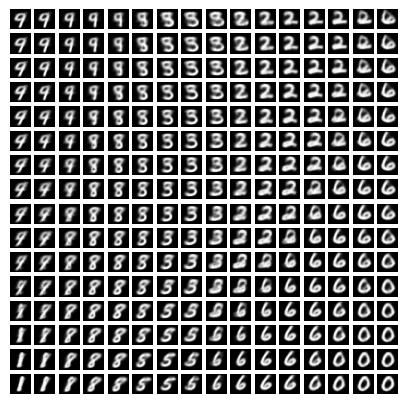

In [ ]:
plt.figure(figsize = (5,5))
k = 0
for i in grid_x:
  for j in grid_y:
    ax= plt.subplot(n,n,k+1)

    input = tf.constant([[i,j]])
    out = model.decoder.predict(input)[0][...,0]
    plt.imshow(out,cmap='Greys_r')
    plt.axis('off')
    k+=1

In [ ]:
(x_train,y_train),_ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype('float32')/255

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


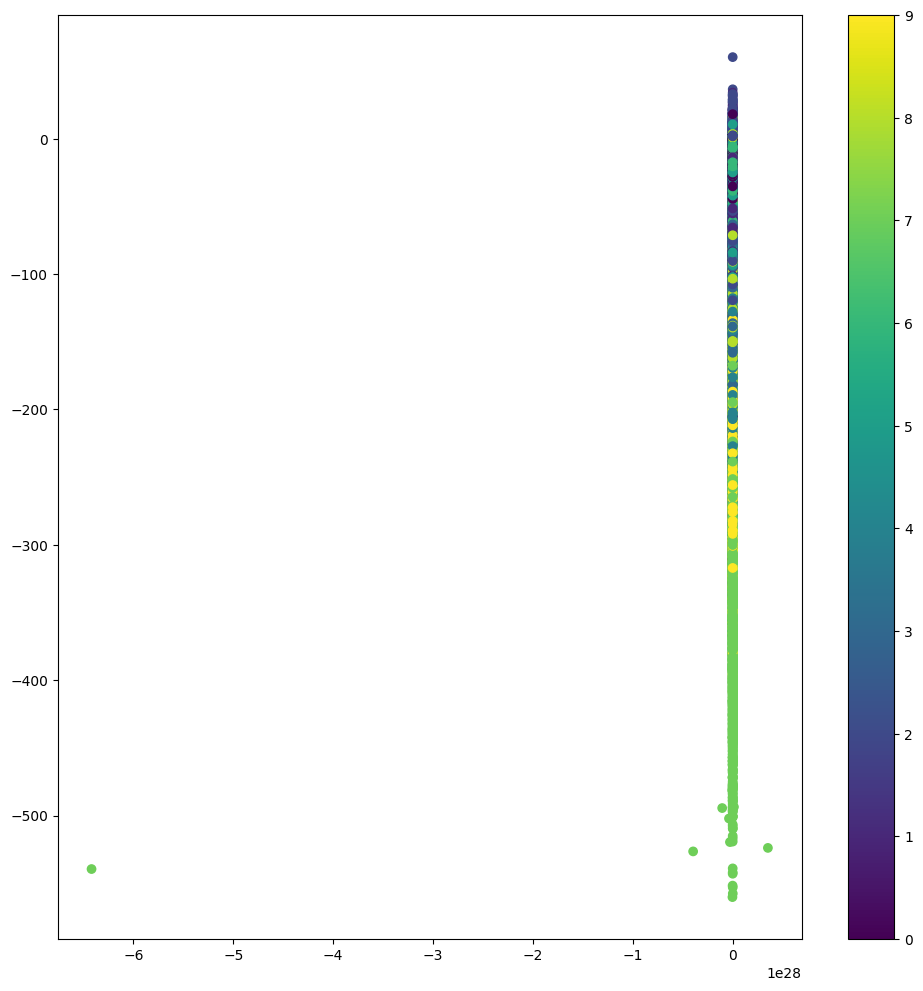

In [ ]:
z,_,_ = vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()